In [25]:
#!pip install geopandas pystac_client rasterio numpy

In [26]:
import json
import os
import geopandas as gpd
from io import StringIO
import pystac_client
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

## Common functions

In [27]:
def initialize_stac_client(stac_url):
    """
    Initialize and return a STAC client for a given STAC API URL.
    Parameters:
    - stac_url (str): The URL of the STAC API.
    Returns:
    - A pystac_client.Client object
    """
    client = pystac_client.Client.open(stac_url)
    return client


def query_stac_api(client, bbox, collections, start_date=None, end_date=None, limit=10):
    """
    Query a STAC API for items within a bounding box and date range for specific collections.
    Parameters:
    - client: The STAC client initialized with `initialize_stac_client`.
    - bbox (list): The bounding box for the query [min_lon, min_lat, max_lon, max_lat].
    - collections (list): A list of collection IDs to include in the query.
    - start_date (str, optional): The start date for the query (YYYY-MM-DD). Defaults to None.
    - end_date (str, optional): The end date for the query (YYYY-MM-DD). Defaults to None.
    - limit (int): Maximum number of items to return.    
    Returns:
    - A list of STAC Items that match the query parameters.
    """

    search_params = {
        "bbox": bbox,
        "collections": collections,
        "limit": limit
    }
    if start_date and end_date:
        search_params["datetime"] = f"{start_date}/{end_date}"

    search = client.search(**search_params)

    items = list(search.items())
    return items


def inspect_stac_item(item):
    """
    Inspects a STAC item and prints out key information to help identify the data type.

    This function iterates over the assets of a given STAC item, printing details such as the
    asset's title, description, media type, and roles. These details can provide insights into
    the nature of the data contained within the item, such as whether it includes satellite imagery,
    elevation data, or other geospatial resources.

    Parameters:
    - item: A STAC item object. This object should conform to the STAC item specification and
            include properties like an ID, datetime, and a dictionary of assets.

    Returns:
    - None: This function does not return any value. It only prints information to the console.
    """

    # Print the unique identifier of the STAC item
    print("Item ID:", item.id)

    # Print the acquisition date of the data, which is stored in the item's properties
    print("Date:", item.properties.get('datetime'))

    # Begin iterating over the assets associated with this STAC item.
    # Assets represent individual data files or resources related to this item.
    print("Assets:")
    for asset_key, asset in item.assets.items():
        # asset_key is the name used to refer to this asset in the STAC item's assets dictionary.
        # asset is the actual asset object, which contains metadata about the data file or resource.

        # Print the key of the asset and its title. The title is a human-readable name for the asset.
        # If no title is provided, it defaults to 'No title'.
        print(f"  - {asset_key}: {asset.title or 'No title'}")

        # Print a description of the asset, which can provide more context about the data it contains.
        # If no description is provided, it defaults to 'No description'.
        print(f"    Description: {asset.description or 'No description'}")

        # Print the media type of the asset, which indicates the format of the data file (e.g., 'image/tiff' for a GeoTIFF file).
        print(f"    Media Type: {asset.media_type}")

        # Print the roles associated with this asset. Roles are used to describe the function of the asset,
        # such as whether it's the primary data ('data'), metadata about the item ('metadata'), a thumbnail image ('thumbnail'), etc.
        # The roles are joined by a comma in case there are multiple roles.
        print(f"    Roles: {', '.join(asset.roles)}")


def get_bbox_from_geodf(geojson_data):
    """
    Extract the bounding box from a GeoJSON-like dictionary.
    Parameters:
    - geojson_data (dict): The GeoJSON data as a Python dictionary.
    Returns:
    - A list representing the bounding box [min_lon, min_lat, max_lon, max_lat].
    """
    gdf = gpd.GeoDataFrame.from_features(geojson_data["features"])
    bbox = list(gdf.total_bounds)
    return bbox


def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.
    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.
    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.
    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = np.nanmin(dem_data)

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = np.nanmax(dem_data)

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = np.nanmean(dem_data)

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = np.nanstd(dem_data)

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats


def create_download_link(filename):
    url = f'{filename}'
    html = f'<a href="{filename}" target="_blank">Download {filename}</a>'
    return HTML(html)


In [28]:
# parameters are applied here

geojson = json.dumps({
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
})


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 458.8737699055928, 'height': 313.7289377387933, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027777777778225824, 0.0, 116.26012130269046,
       0.0, -0.00027777777778225824, -29.220237788279103)}


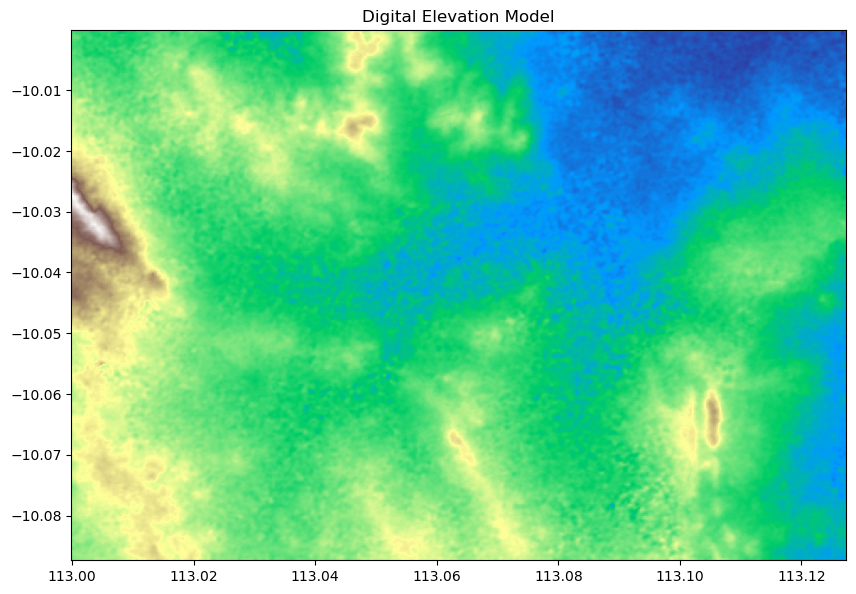

{'min_elevation': 265.2571, 'max_elevation': 421.13367, 'mean_elevation': 312.53452, 'std_dev_elevation': 19.763508}


In [29]:
import rasterio.plot

req = json.loads(geojson)
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
stac_url_rgb = "https://earth-search.aws.element84.com/v1"
collections_dem = ['ga_srtm_dem1sv1_0']
collections_rgb = ['sentinel-2-l2a']

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

# Initialize STAC clients
client_dem = initialize_stac_client(stac_url_dem)
client_rgb = initialize_stac_client(stac_url_rgb)

start_date = "2023-01-01"
end_date = "2023-03-01"

# Query STAC catalogs
items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None)
items_rgb = query_stac_api(client_rgb, bbox, collections_rgb, start_date, end_date)

# Only want the dem asset
item = items_dem[0]
dem_asset = item.assets.get('dem')

# Process the dem asset
with rasterio.open(dem_asset.href) as src:
    # Convert the GeoJSON bounds to a rasterio window
    window = from_bounds(*bbox, transform=src.transform)

    # Read the data within the window
    data = src.read(window=window)

    # Preserve the metadata from the dem asset
    kwargs = src.meta.copy()
    # Updating the metadata based on the bounding box of our original geojson
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, src.transform)
    })
    
    output_tiff = 'digital-elevation-model2.tiff'
    with rasterio.open(output_tiff, 'w', **kwargs) as dst:
        dst.write(data)
        
print(kwargs)
elevation_stats = compute_elevation_statistics(data)

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='terrain')
ax.set_title('Digital Elevation Model')
plt.show()

# Save the data as a geospatial TIFF


print(elevation_stats)


In [30]:
# Preview the metadata on the generated tiff

with rasterio.open(output_tiff) as src:
    print("Metadata:", src.meta)
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)


Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 458, 'height': 313, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027777777778225824, 0.0, 116.26012130269046,
       0.0, -0.00027777777778225824, -29.220237788279103)}
CRS: EPSG:4326
Bounds: BoundingBox(left=116.26012130269046, bottom=-29.30718223272495, right=116.38734352491474, top=-29.220237788279103)


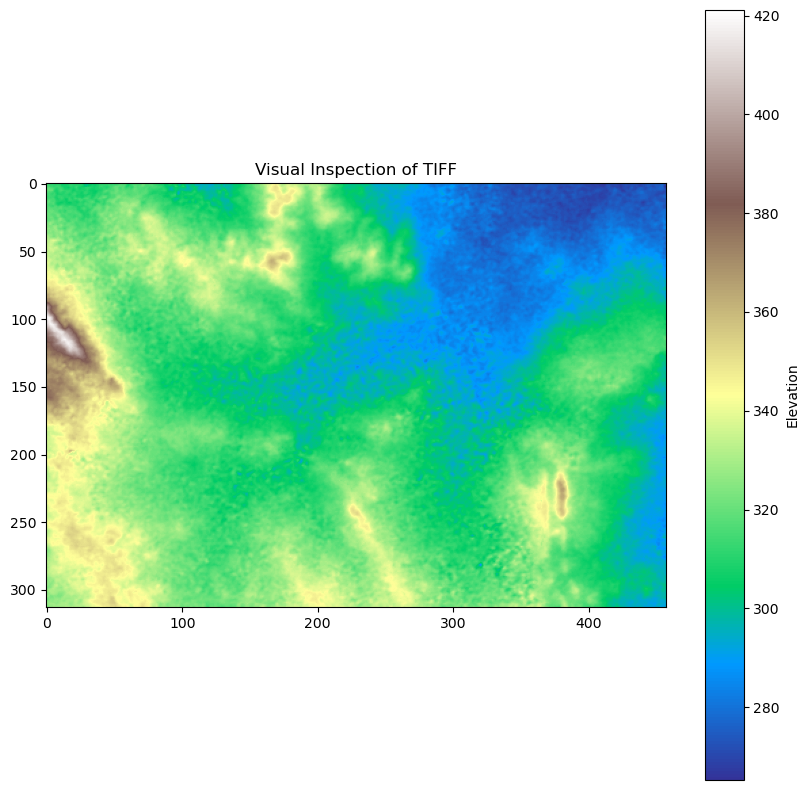

In [31]:
# Preview the generated tiff

with rasterio.open(output_tiff) as src:
    preview_data = src.read(1)  # Read the first band into 'data'

    plt.figure(figsize=(10, 10))
    plt.imshow(preview_data, cmap='terrain')  # Use an appropriate colormap
    plt.colorbar(label='Elevation')
    plt.title('Visual Inspection of TIFF')
    plt.show()

In [32]:
html = f'<a href="{output_tiff}" download="{output_tiff}"><button>Download TIFF Image</button></a>'
HTML(html)